In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import shap

/Applications/miniconda3/envs/mlbenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in formatted dataset
# assume repo root is two levels up from this notebook
ROOT = Path.cwd().parents[1]  # adjust if needed
DATA_DIR = ROOT / "data"

print(DATA_DIR)

print(ROOT)

df = pd.read_parquet(r"../../data/2023-03-30_2025-09-30_pitches_description_whiff_csw_stats_flattened.parquet")


/Users/matthewgillies/PitchArsenalModelling/data
/Users/matthewgillies/PitchArsenalModelling


In [3]:
df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,self_usage,self_velo,self_HB,self_IVB,self_VAA,self_HAA,self_spin,self_ext,self_rel_x,self_rel_z
0,425794,CH,2023,89,0.100000,0.134831,R,81.431461,-4.546824,0.9675,...,0.049860,81.431461,-14.02382,8.755955,-4.546824,0.9675,1655.179775,6.511236,-1.335618,6.14236
1,425794,CU,2023,546,0.149378,0.252747,R,71.506044,-4.591665,1.387363,...,0.305882,71.506044,16.566374,-13.550989,-4.591665,1.387363,2647.908918,6.32334,-1.24359,6.284817
2,425794,FC,2023,404,0.146597,0.220297,R,82.852228,-4.121794,1.857984,...,0.226331,82.852228,5.577624,7.672574,-4.121794,1.857984,2321.953368,6.491688,-1.215272,6.287401
3,425794,FF,2023,178,0.100000,0.297753,R,85.73427,-3.745816,0.994451,...,0.099720,85.73427,-1.866742,14.824045,-3.745816,0.994451,2158.635294,6.530588,-1.232697,6.247135
4,425794,SI,2023,560,0.071429,0.260714,R,86.875,-4.051163,1.253781,...,0.313725,86.875,-13.252929,11.164071,-4.051163,1.253781,2167.058052,6.551685,-1.284518,6.134482


In [4]:
df.shape

(8397, 205)

In [5]:
df.isna().sum().sort_values(ascending=False)

SC_VAA        8390
SC_HAA        8390
SC_usage      8390
SC_velo       8390
SC_HB         8390
              ... 
IVB              0
pitch_type       0
has_CH           0
has_CS           0
self_rel_z       0
Length: 205, dtype: int64

In [ ]:
# drop nas -> not a large proportion
# df = df.dropna()

In [9]:
df.shape

(8397, 205)

In [10]:
# drop duplicates in pitcher/season/pitch_type
df = df.drop_duplicates(subset=["pitcher", "season", "pitch_type"])
df.shape

(8397, 205)

In [59]:
# filter to FF only for initial analysis
ff_df = df[df["pitch_type"] == "SL"]

# filter to min 60 pitches thrown
ff_filtered = ff_df[ff_df['pitches'] > 60]

In [60]:
ff_df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,self_usage,self_velo,self_HB,self_IVB,self_VAA,self_HAA,self_spin,self_ext,self_rel_x,self_rel_z
10,425844,SL,2023,444,0.217778,0.238739,R,79.16982,-4.399705,2.113677,...,0.200090,79.16982,13.576757,2.424865,-4.399705,2.113677,2464.178733,5.883559,-1.421194,6.155698
20,434378,SL,2023,709,0.267030,0.273625,R,86.877151,-5.255454,2.203544,...,0.254578,86.877151,4.515317,3.808181,-5.255454,2.203544,2513.184023,5.974612,-1.528209,6.974245
21,434378,SL,2024,305,0.202454,0.236066,R,86.699016,-5.364313,2.287399,...,0.193038,86.699016,4.001705,5.91423,-5.364313,2.287399,2441.642623,5.967541,-1.616951,7.069148
22,434378,SL,2025,623,0.307910,0.280899,R,87.108186,-5.443943,2.402287,...,0.231943,87.108186,4.06825,5.496886,-5.443943,2.402287,2496.504013,6.022953,-1.868491,7.065939
30,445276,SL,2023,86,0.375000,0.255814,R,84.139535,-4.846906,2.385485,...,0.119279,84.139535,7.240465,-3.795349,-4.846906,2.385485,2423.127907,6.774419,-2.413721,6.241047


In [61]:
ff_df.shape

(1386, 205)

In [62]:
# plot top 10 correlations with whiff_rate
correlations = ff_filtered.select_dtypes("number").corr()["whiff_pct"].abs().sort_values(ascending=False
)
top_10_features = correlations.index[1:11]  # exclude whiff_rate itself
print("Top 10 features correlated with whiff_rate:")
print(top_10_features)

Top 10 features correlated with whiff_rate:
Index(['CS_rel_z', 'CS_IVB', 'CS_velo', 'CS_spin', 'CS_HAA', 'CS_VAA',
       'CS_usage', 'CS_HB', 'CS_rel_x', 'whiff_pct'],
      dtype='object')


In [63]:
# create correlation heatmap for features with traget (whiff_pct)
# import seaborn as sns
# corr = ff_df.select_dtypes(include=[np.number]).corr()
# plt.figure(figsize=(24, 24))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [64]:
# develop base xgboost workflow 
cat_cols = ['p_throws'] + [col for col in ff_df.columns if col.startswith('has_')]

target = "whiff_pct"

# 1) train/val split by pitcher - when we have multiple seasons with same pitches
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ff_df, groups=ff_df["pitcher"]))

train = ff_df.iloc[train_idx].copy()
val   = ff_df.iloc[val_idx].copy()

# 2) choose features (exclude ids + targets)
drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns])

y_train = train[target].values
y_val   = val[target].values

# 3) one-hot categorical cols (simple + reliable)
X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val, columns=cat_cols, dummy_na=True)

# align columns
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)

# 4) sample weights to reflect stability of rate targets
w_train = train["pitches"].values  # or np.sqrt(train["pitches"].values)

model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.001,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=2.0,
    reg_alpha=2.0,
    min_child_weight=5,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)

# train metrics:

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)
print("Train RMSE:", train_rmse, "R2:", train_r2)

pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)

print("RMSE:", rmse, "R2:", r2)

Train RMSE: 0.09074649538506942 R2: 0.27651887543974407
RMSE: 0.09006907409048823 R2: 0.20657471415794193


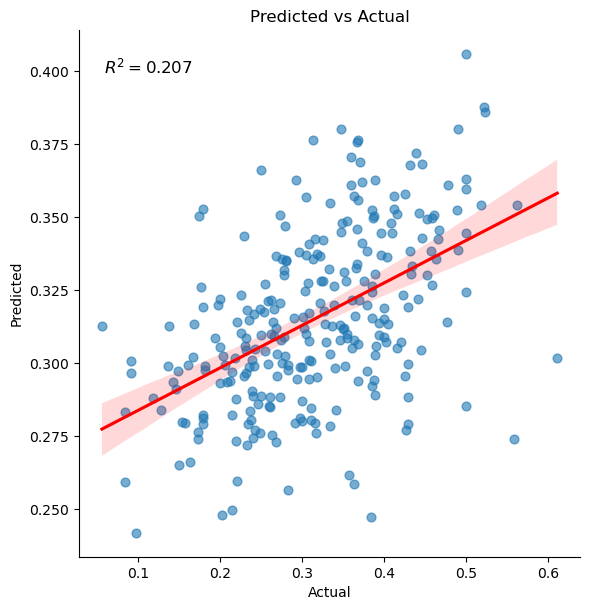

In [65]:
# seaborn lmplot of predicted vs actual
# Build plotting dataframe
import seaborn as sns
plot_df = pd.DataFrame({
    "actual": y_val,
    "predicted": pred
})

# Plot
g = sns.lmplot(
    data=plot_df,
    x="actual",
    y="predicted",
    height=6,
    aspect=1,
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"color": "red"}
)

# Annotate R^2
plt.text(
    0.05, 0.95,
    f"$R^2 = {r2:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")

plt.show()



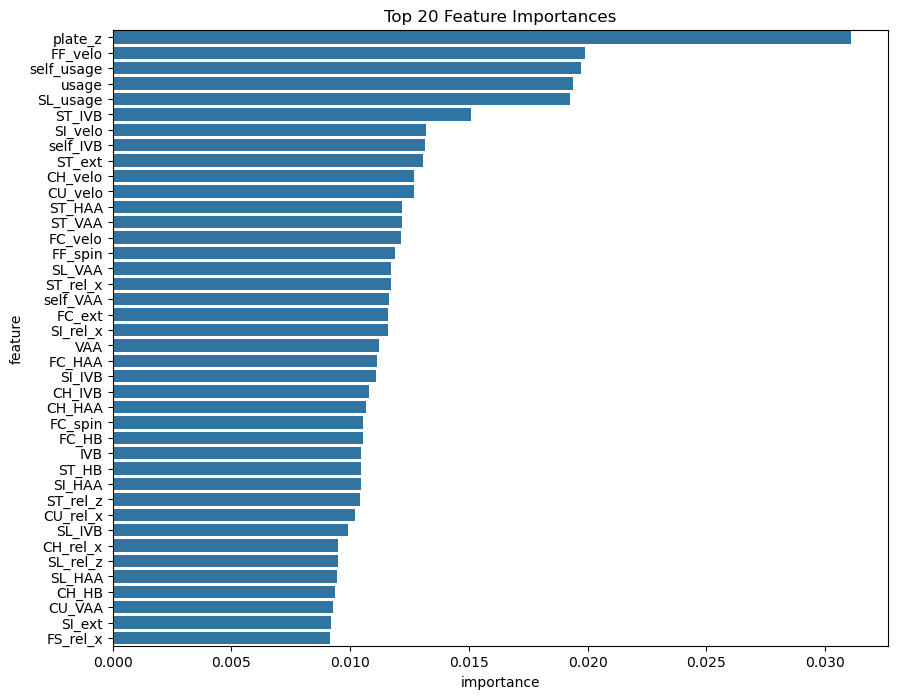

In [66]:
# plot feature importance
importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(40))
plt.title("Top 20 Feature Importances")
plt.show()

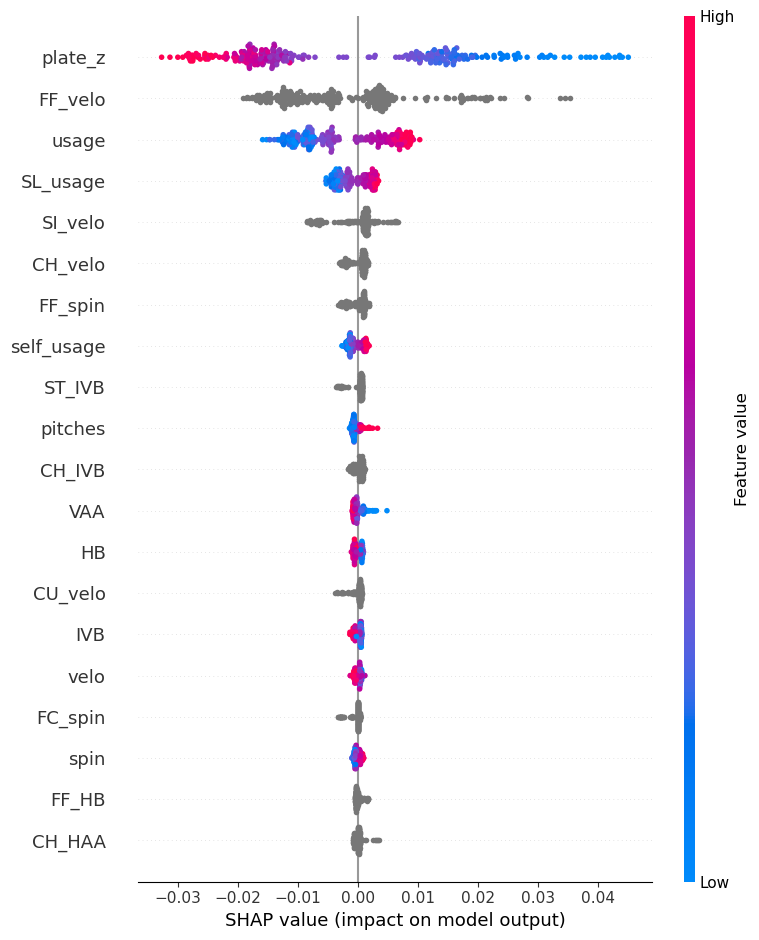

In [67]:
# shap explainer and summary plot
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

# Workflow to look at individual player predictions

In [68]:
from pybaseball import playerid_lookup

def get_mlbam_id(first: str, last: str) -> int:
    """
    Returns MLBAM id (key_mlbam) for a player name.
    If multiple results, returns the first row (you can disambiguate by birth year if needed).
    """
    res = playerid_lookup(last, first)
    if res.empty:
        raise ValueError(f"No player found for {first} {last}")

    # key_mlbam is what Statcast 'pitcher' column uses
    mlbam = res.iloc[0]["key_mlbam"]
    if pd.isna(mlbam):
        raise ValueError(f"Found player but no MLBAM id for {first} {last}")

    return int(mlbam)

# Example:
pitcher_id = get_mlbam_id("Gerrit", "Cole")
pitcher_id


543037

In [69]:
import pandas as pd

def preprocess_single_row(row_df, cat_cols, model_columns):
    """
    Preprocess a single-row dataframe to match X_train exactly.
    """
    X = row_df.copy()

    # ensure categoricals are strings and fill NA
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype("string").fillna("NONE")

    # one-hot encode
    X = pd.get_dummies(X, columns=cat_cols, dummy_na=True)

    # align columns to training matrix
    X = X.reindex(columns=model_columns, fill_value=0)

    return X



In [70]:
import shap
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup

def explain_one_prediction(
    features_df,
    model,
    model_columns,
    cat_cols,
    first,
    last,
    season,
    pitch_type="FF"
):
    # --- lookup MLBAM id ---
    pid_df = playerid_lookup(last, first)
    if pid_df.empty:
        raise ValueError(f"No player found for {first} {last}")

    pitcher_id = int(pid_df.iloc[0]["key_mlbam"])

    # --- select row ---
    row = features_df[
        (features_df["pitcher"] == pitcher_id) &
        (features_df["season"] == season) &
        (features_df["pitch_type"] == pitch_type)
    ].copy()

    if row.empty:
        raise ValueError(f"No row for {first} {last}, {season}, {pitch_type}")

    # if somehow duplicated, take most-used
    if len(row) > 1:
        row = row.loc[[row["pitches"].idxmax()]]

    # --- drop non-features (exactly like training) ---
    drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
    X_pre = row.drop(columns=[c for c in drop_cols if c in row.columns])

    # --- preprocess to match model ---
    X_row = preprocess_single_row(
        X_pre,
        cat_cols=cat_cols,
        model_columns=model_columns
    )

    # --- prediction ---
    pred = float(model.predict(X_row)[0])

    # --- SHAP ---
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_row)

    # Waterfall plot (best for single prediction)
    shap.plots.waterfall(shap_values[0], max_display=20)

    return {
        "pitcher_id": pitcher_id,
        "season": season,
        "pitch_type": pitch_type,
        "prediction": pred,
        "raw_row": row,
        "X_row": X_row,
        "shap_values": shap_values
    }



In [71]:
# Get pitchers from X_val:

val.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,self_usage,self_velo,self_HB,self_IVB,self_VAA,self_HAA,self_spin,self_ext,self_rel_x,self_rel_z
30,445276,SL,2023,86,0.375000,0.255814,R,84.139535,-4.846906,2.385485,...,0.119279,84.139535,7.240465,-3.795349,-4.846906,2.385485,2423.127907,6.774419,-2.413721,6.241047
31,445276,SL,2024,49,0.055556,0.163265,R,82.471429,-4.672131,2.474298,...,0.060345,82.471429,6.227755,-3.808163,-4.672131,2.474298,2421.326531,6.669388,-2.068367,6.458571
32,445276,SL,2025,55,0.225000,0.236364,R,83.696364,-4.804873,2.379356,...,0.060044,83.696364,7.232727,-3.277091,-4.804873,2.379356,2456.709091,6.810909,-2.170545,6.374182
172,477132,SL,2023,879,0.338920,0.310580,L,86.532651,-4.635693,-2.080848,...,0.433860,86.532651,-5.367645,6.723823,-4.635693,-2.080848,2475.265143,6.437699,1.558396,6.170046
173,477132,SL,2024,220,0.258065,0.268182,L,85.934545,-4.545493,-2.096151,...,0.436508,85.934545,-4.846364,6.843818,-4.545493,-2.096151,2435.790909,6.406818,1.655773,6.110091


In [76]:
# get playerr name from id: 
from pybaseball import playerid_reverse_lookup

# single id
for i in range(len(val)):
    print(val.iloc[i])
    print(playerid_reverse_lookup([val['pitcher'].iloc[i]], key_type="mlbam")[['name_first', 'name_last']])


pitcher            445276
pitch_type             SL
season               2023
pitches                86
whiff_pct           0.375
                 ...     
self_HAA         2.385485
self_spin     2423.127907
self_ext         6.774419
self_rel_x      -2.413721
self_rel_z       6.241047
Name: 30, Length: 205, dtype: object
  name_first name_last
0     kenley    jansen
pitcher            445276
pitch_type             SL
season               2024
pitches                49
whiff_pct        0.055556
                 ...     
self_HAA         2.474298
self_spin     2421.326531
self_ext         6.669388
self_rel_x      -2.068367
self_rel_z       6.458571
Name: 31, Length: 205, dtype: object
  name_first name_last
0     kenley    jansen
pitcher            445276
pitch_type             SL
season               2025
pitches                55
whiff_pct           0.225
                 ...     
self_HAA         2.379356
self_spin     2456.709091
self_ext         6.810909
self_rel_x      -2.170545
se

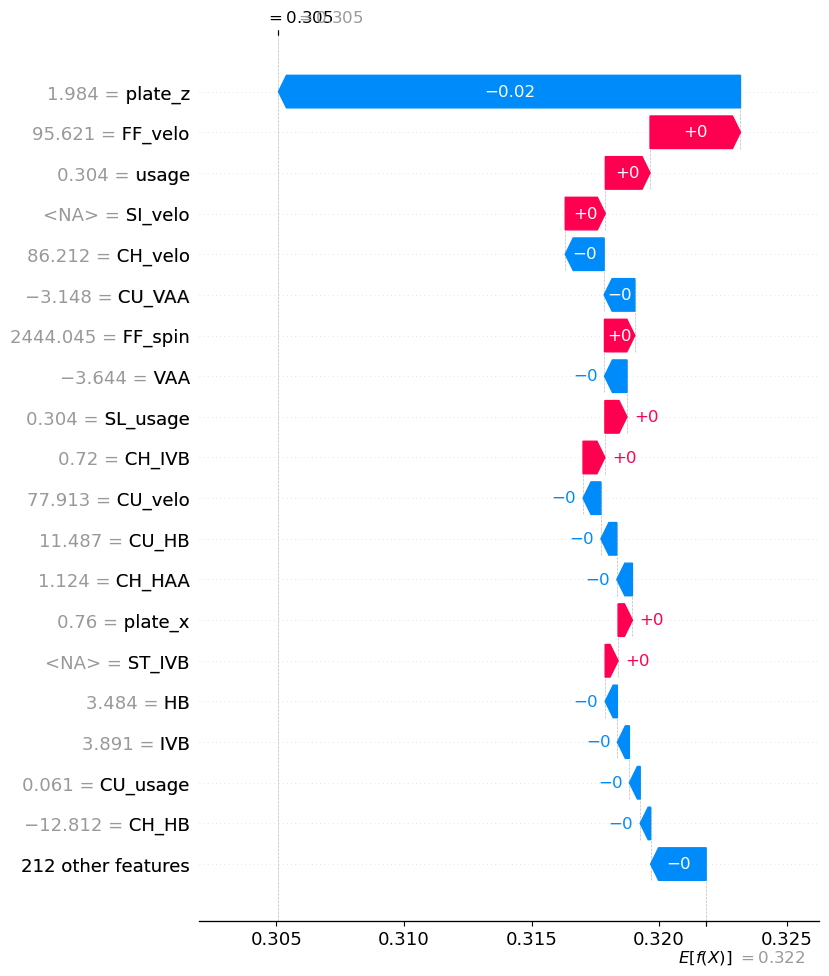

Predicted SL whiff%: 0.3050815463066101


,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,self_usage,self_velo,self_HB,self_IVB,self_VAA,self_HAA,self_spin,self_ext,self_rel_x,self_rel_z
7433,686218,SL,2025,348,0.415385,0.37069,R,87.821552,-3.643887,2.083395,...,0.303665,87.821552,3.484138,3.89069,-3.643887,2.083395,2352.178161,6.628161,-1.199368,5.414741


In [77]:
model_columns = X_train.columns

out = explain_one_prediction(
    features_df=df,   # your full season-level table
    model=model,
    model_columns=model_columns,
    cat_cols=cat_cols,
    first="Emmet",
    last="Sheehan",
    season=2025,
    pitch_type="SL"
)

print("Predicted SL whiff%:", out["prediction"])
out["raw_row"]
